# Task 2-1: Three-body problem


In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch, time, sys
import numpy as np
import scipy.integrate, scipy.ndimage
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = '../experiment-body-3+'
sys.path.append(EXPERIMENT_DIR)

MODEL_DIR = '../src'
sys.path.append(MODEL_DIR)

from layers import MLP
from models import HNN, ModLaNet
from utils import L2_loss
from data import Dataset

In [2]:
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"]  = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
wordsize = 18
plt.rc('font', size=wordsize)          # controls default text sizes
plt.rc('axes', titlesize=wordsize)     # fontsize of the axes title
plt.rc('axes', labelsize=wordsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=wordsize)    # legend fontsize
plt.rc('figure', titlesize=wordsize)  # fontsize of the figure title

## Set some notebook constants

In [4]:
DPI = 300
FORMAT = 'png'

def get_args():
    return {'obj': 3,
            'dof': 2,
            'dim': 2,
            'hidden_dim': 200,
            'nonlinearity': 'tanh',
            'trans_hidden_dim': 16,
            'trans_nonlinearity': 'tanh',
            'energy_hidden_dim': 50,
            'energy_nonlinearity': 'tanh',
            'learn_rate': 1e-3,
            'input_noise': 0.,
            'batch_size': 600,
            'total_steps': 1500,
            'field_type': 'solenoidal',
            'print_every': 200,
            'verbose': True,
            'name': 'body',
            'seed': 66,
            'save_dir': '{}'.format(EXPERIMENT_DIR+'/data'),
            'result_dir': '../results'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView(get_args())

## Construct models

In [5]:
def BuildComputationTree(transform = 'local', obj=3, dim=2, dof=2, device = 'cpu'):
    r"""
    User defined relations between elements and origins of local coordinate systems.
    We assume that these connections between origins and elements 
    can be obtained when local coordinate systems are constructed.

    Function: x_{i, origin} =   \sum_j x_{j, element} * weight_j + 
                                \sum_k x_{k, origin}  * weight_k + 
                                weight_c
    Form: [i, 
            [[j1, weight_j1], [j2, weight_j2], ...], 
            [[k1, weight_k1], [k2, weight_k2], ...], 
            weight_c]
    """
    tree = None
    if transform == 'local':
        ################################
        # User defined relations start #
        ################################
        pass
        ################################
        # User defined relations end   #
        ################################
    return tree

In [6]:
def get_model(args, model_name, end_epoch, noise, learn_rate, hidden_dim = None, load_obj = None):
    load_obj = args.obj if load_obj is None else load_obj
    hidden_dim = args.hidden_dim if hidden_dim is None else hidden_dim
    path = '{}/model-{}-{}-{}-hidden_dim-{}-end_epoch-{}-noise-{}-learn_rate-{}.tar'.format(args.save_dir, load_obj, args.name,
                                                                           model_name, hidden_dim, end_epoch,
                                                                           noise, learn_rate)
    checkpoint = torch.load(path)
    if model_name == 'modlanet':
        model = ModLaNet(obj=load_obj, dim=args.dim, edof=args.dof, build_computation_tree=BuildComputationTree, transform = 'global',
                         trans_hidden_dim = args.trans_hidden_dim, trans_nonlinearity = args.trans_nonlinearity, 
                         energy_hidden_dim = args.energy_hidden_dim, energy_nonlinearity=args.energy_nonlinearity)
        model.load_state_dict(checkpoint['network_state_dict'])
    else:
        assert load_obj == args.obj
        input_dim = args.obj * args.dof * 2
        output_dim = input_dim if model_name == 'baseline' else 2
        nn_model = MLP(input_dim, hidden_dim, output_dim, nonlinearity=args.nonlinearity)
        model = HNN(input_dim, differentiable_model=nn_model,
                  field_type=args.field_type, baseline= (model_name == 'baseline') )

        model.load_state_dict(checkpoint['network_state_dict'])
    return model

In [7]:
def integrate_model(args, model, t_span, y0, model_name = 'modlanet', **kwargs):
    if model_name == 'modlanet':
        def fun(t, np_x):
            x = torch.tensor( np_x[:args.obj*args.dof], requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            v = torch.tensor( np_x[args.obj*args.dof:], requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            dx = model.forward(x, v).data.numpy().reshape(-1)
            return np.concatenate((np_x[args.obj*args.dof:], dx))
    else:
        def fun(t, np_x):
            x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof*2)
            dx = model.time_derivative(x).data.numpy().reshape(-1)
            return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [8]:
# model_name, end_epoch, noise, learn_rate

modlanet_model = get_model(args, model_name = 'modlanet', end_epoch = 3000, hidden_dim = 50, noise = 0., learn_rate = 0.001)
base_model = get_model(args, model_name = 'baseline', end_epoch = 3000, noise = 0., learn_rate = 0.001)
hnn_model  = get_model(args, model_name = 'hnn', end_epoch = 3000, noise = 0., learn_rate = 0.001)
base_light_model = get_model(args, model_name = 'baseline', end_epoch = 3000, noise = 0., learn_rate = 0.001, hidden_dim = 70)
hnn_light_model  = get_model(args, model_name = 'hnn', end_epoch = 3000, noise = 0., learn_rate = 0.001, hidden_dim = 70)


## Visualize one example from dataset

In [9]:
np.random.seed(args.seed)

In [10]:
ds = Dataset(args.obj, m= [1. for i in range(args.obj)])
y0 = ds.random_config()
timescale = 20
end_time = 30
t_span = [0, end_time]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], end_time*timescale+1), 'rtol': 1e-12}

tra1 = ds.get_trajectory(t_span = t_span, y0=y0, timescale = timescale, system='modlanet')
modlanet_ivp = integrate_model(args, modlanet_model, t_span, y0, model_name = 'modlanet', **kwargs)
hnn_ivp = integrate_model(args, hnn_model, t_span, y0, model_name = 'hnn', **kwargs)
base_ivp = integrate_model(args, base_model, t_span, y0, model_name = 'base', **kwargs)

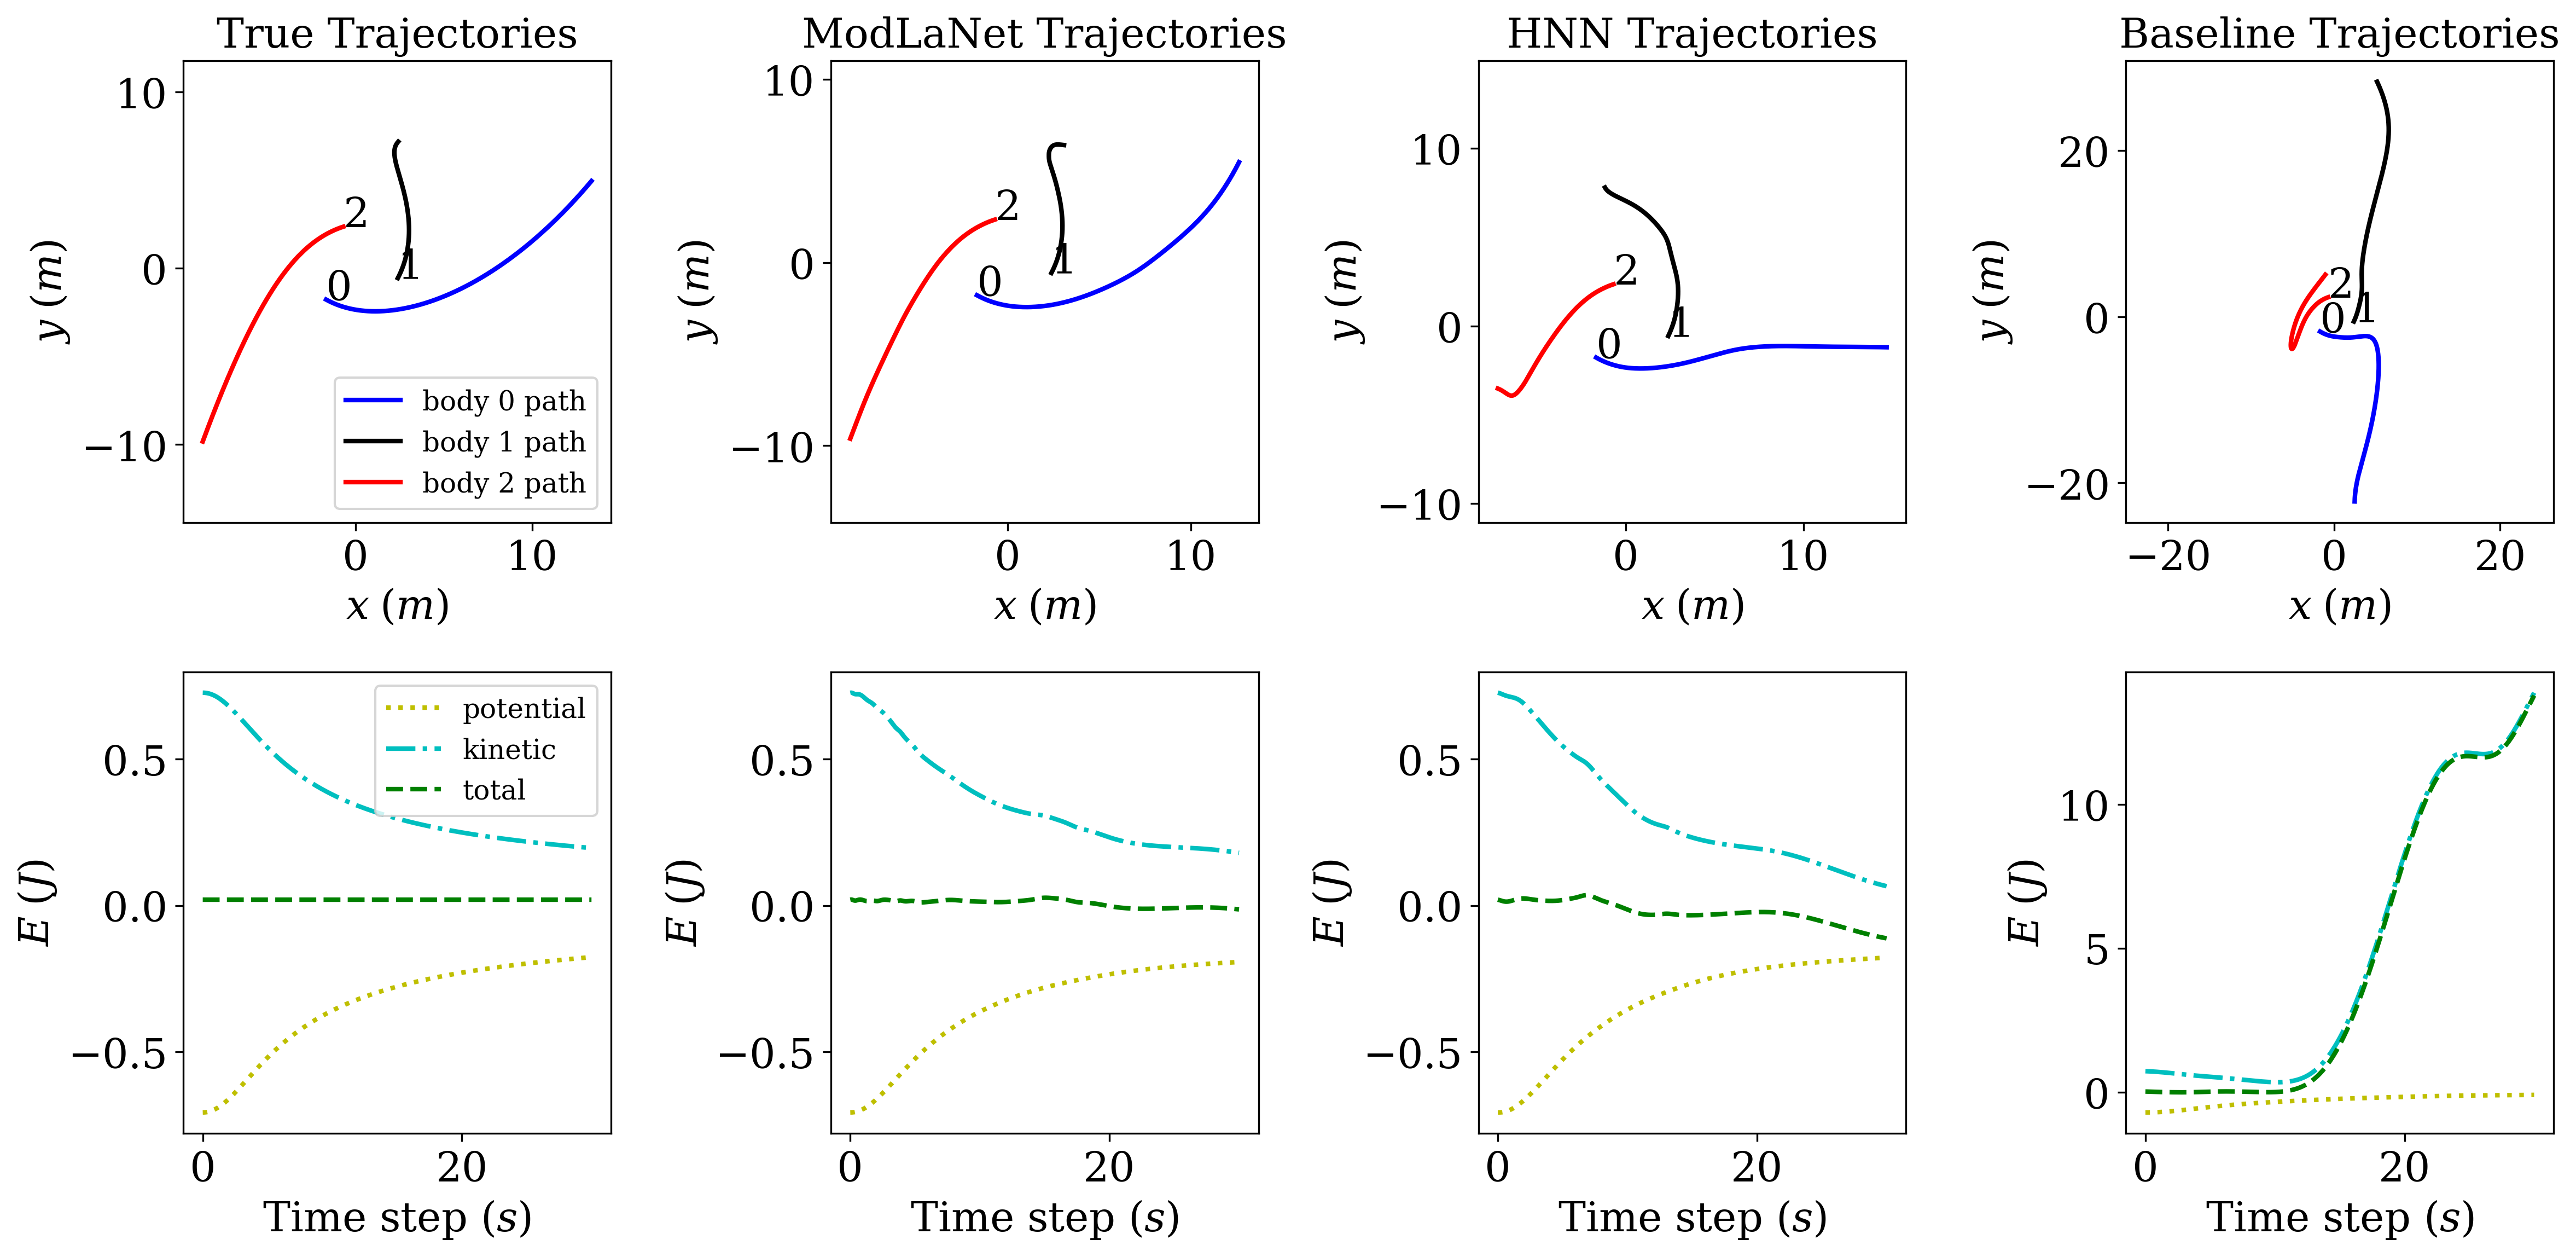

In [11]:
fig = plt.figure(figsize=(16, 8), dpi=DPI)

x, v, ac, t, E = tra1
coords = np.concatenate([x.T, v.T], axis = 0)
T, U = ds.lagrangian_kinetic(coords), ds.lagrangian_potential(coords)
colors = ['b', 'k', 'r']
lines  = [':', '-.', '--']

plt.subplot(241)
plt.title('True Trajectories')
for i in range(args.obj):
    plt.text(x[0, i*2], x[0, i*2+1], '{}'.format(i))
    plt.plot(x[:, i*2], x[:, i*2+1], color = colors[i], label='body {} path'.format(i), linewidth=2)
plt.axis('equal')
plt.xlabel('$x\;(m)$') ; plt.ylabel('$y\;(m)$')
plt.legend(loc='lower right', fontsize=12)

plt.subplot(245)
plt.xlabel('Time step $(s)$'); plt.ylabel('$E\;(J)$')
plt.plot(t, U,  'y:', label='potential', linewidth=2)
plt.plot(t, T,  'c-.', label='kinetic', linewidth=2)
plt.plot(t, U+T,  'g--', label='total', linewidth=2)
plt.legend(fontsize=12)

y, t = base_ivp['y'], base_ivp['t']
plt.subplot(244)
plt.title('Baseline Trajectories')
for i in range(args.obj):
    plt.text(x[0, i*2], x[0, i*2+1], '{}'.format(i))
    plt.plot(y[2*i], y[2*i+1], color = colors[i], label='body {} path'.format(i), linewidth=2)
plt.axis('equal')
plt.xlabel('$x\;(m)$') ; plt.ylabel('$y\;(m)$')
# plt.legend(loc='upper left', fontsize=12)

T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
plt.subplot(248)
plt.xlabel('Time step $(s)$'); plt.ylabel('$E\;(J)$')
plt.plot(t, U,  'y:', label='potential', linewidth=2)
plt.plot(t, T,  'c-.', label='kinetic', linewidth=2)
plt.plot(t, U+T,  'g--', label='total', linewidth=2)
# plt.legend(fontsize=12)

y, t = hnn_ivp['y'], hnn_ivp['t']
plt.subplot(243)
plt.title('HNN Trajectories')
for i in range(args.obj):
    plt.text(x[0, i*2], x[0, i*2+1], '{}'.format(i))
    plt.plot(y[2*i], y[2*i+1], color = colors[i], label='body {} path'.format(i), linewidth=2)
plt.axis('equal')
plt.xlabel('$x\;(m)$') ; plt.ylabel('$y\;(m)$')
# plt.legend(loc='upper left', fontsize=12)


T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
plt.subplot(247)
plt.xlabel('Time step $(s)$'); plt.ylabel('$E\;(J)$')
plt.plot(t, U,  'y:', label='potential', linewidth=2)
plt.plot(t, T,  'c-.', label='kinetic', linewidth=2)
plt.plot(t, U+T,  'g--', label='total', linewidth=2)
# plt.legend(fontsize=12)


y, t = modlanet_ivp['y'], modlanet_ivp['t']
plt.subplot(242)
plt.title('ModLaNet Trajectories')
for i in range(args.obj):
    plt.text(x[0, i*2], x[0, i*2+1], '{}'.format(i))
    plt.plot(y[2*i], y[2*i+1], color = colors[i], label='body {} path'.format(i), linewidth=2)
plt.axis('equal')
plt.xlabel('$x\;(m)$') ; plt.ylabel('$y\;(m)$')
# plt.legend(loc='upper left', fontsize=12)


T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
plt.subplot(246)
# plt.title('Energy') ; 
plt.xlabel('Time step $(s)$'); plt.ylabel('$E\;(J)$')
plt.plot(t, U,  'y:', label='potential', linewidth=2)
plt.plot(t, T,  'c-.', label='kinetic', linewidth=2)
plt.plot(t, U+T,  'g--', label='total', linewidth=2)
# plt.legend(fontsize=12)

plt.tight_layout()
fig.savefig('{}/body-3-integration.{}'.format(args.result_dir, FORMAT), bbox_inches="tight")

## Calculate bar error over 100 trajectoies

In [12]:
# Be careful! It will take a while.
# Uncomment the code below for checking.

print('Be careful to run it! It will take a while.')
"""
num_models = 6
x_list, e_list, k_list, p_list = [[] for i in range(num_models)], [[] for i in range(num_models)], [[] for i in range(num_models)], [[] for i in range(num_models)]
for i in range(100):
    print(i)
    np.random.seed(i)
    ds = Dataset(args.obj, m= [1. for i in range(args.obj)], l= [1. for i in range(args.obj)])
    y0 = ds.random_config()
    timescale = 20
    end_time = 30
    t_span = [0, end_time]
    kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], end_time*timescale+1), 'rtol': 1e-12}

    truth_ivp = ds.get_trajectory(t_span = t_span, y0=y0, timescale = timescale, system='modlanet')
    x, v, _, _, E = truth_ivp
    coords = np.concatenate([x.T, v.T], axis = 0)
    T, U = ds.lagrangian_kinetic(coords), ds.lagrangian_potential(coords)
    j = 0
    x_list[j].append(x.T)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    
    modlanet_ivp = integrate_model(args, modlanet_model, t_span, y0, model_name = 'modlanet', **kwargs)
    y = modlanet_ivp['y']
    x = modlanet_ivp['y'][:args.obj*args.dim]
    T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
    j = 1
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    
    hnn_ivp = integrate_model(args, hnn_model, t_span, y0, model_name = 'hnn', **kwargs)
    x = hnn_ivp['y'][:args.obj*args.dim]
    y = hnn_ivp['y']
    T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
    j = 2
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    
    base_ivp = integrate_model(args, base_model, t_span, y0, model_name = 'base', **kwargs)
    x = base_ivp['y'][:args.obj*args.dim]
    y = base_ivp['y']
    T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
    j = 3
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    
    hnn_light_ivp = integrate_model(args, hnn_light_model, t_span, y0, model_name = 'hnn', **kwargs)
    x = hnn_light_ivp['y'][:args.obj*args.dim]
    y = hnn_light_ivp['y']
    T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
    j = 4
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    
    base_light_ivp = integrate_model(args, base_light_model, t_span, y0, model_name = 'base', **kwargs)
    x = base_light_ivp['y'][:args.obj*args.dim]
    y = base_light_ivp['y']
    T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
    j = 5
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
np.save('{}/analysis-body-3.npy'.format(args.result_dir), {'x_list':np.array(x_list), 'e_list':np.array(e_list)})
"""

Be careful to run it! It will take a while.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
results = np.load('{}/analysis-body-3.npy'.format(args.result_dir), allow_pickle=True).item()
x_list, e_list = results['x_list'], results['e_list']
end_time = 30
timescale = 20
t_span = [0, end_time]

In [14]:
modlanet_error, base_error, hnn_error = [[] for _ in range(4)],[[] for _ in range(4)],[[] for _ in range(4)]
base_light_error, hnn_light_error = [[] for _ in range(4)],[[] for _ in range(4)],

j = 0
length = len(e_list[0][0])
for i in range(100):
    modlanet_error[j].append(np.linalg.norm(x_list[0][i]-x_list[1][i])/length)
    hnn_error[j].append(np.linalg.norm(x_list[0][i]-x_list[2][i])/length) 
    base_error[j].append(np.linalg.norm(x_list[0][i]-x_list[3][i])/length)    
    hnn_light_error[j].append(np.linalg.norm(x_list[0][i]-x_list[4][i])/length) 
    base_light_error[j].append(np.linalg.norm(x_list[0][i]-x_list[5][i])/length) 
    
print('Mean error and std of position:')
print('modlanet:  {:.5f} +/- {:.5f}'.format(np.mean(modlanet_error[j]), np.std(modlanet_error[j])))
print('hnn:       {:.5f} +/- {:.5f}'.format(np.mean(hnn_error[j]), np.std(hnn_error[j])))
print('baseline:  {:.5f} +/- {:.5f}'.format(np.mean(base_error[j]), np.std(base_error[j])))
print('light hnn: {:.5f} +/- {:.5f}'.format(np.mean(hnn_light_error[j]), np.std(hnn_light_error[j])))
print('light baseline: {:.5f} +/- {:.5f}'.format(np.mean(base_light_error[j]), np.std(base_light_error[j])))
print('')

j = 1
for i in range(100):
    modlanet_error[j].append(np.linalg.norm(e_list[0][i]-e_list[1][i])/length)
    hnn_error[j].append(np.linalg.norm(e_list[0][i]-e_list[2][i])/length) 
    base_error[j].append(np.linalg.norm(e_list[0][i]-e_list[3][i])/length)    
    hnn_light_error[j].append(np.linalg.norm(e_list[0][i]-e_list[4][i])/length) 
    base_light_error[j].append(np.linalg.norm(e_list[0][i]-e_list[5][i])/length) 
print('Mean error and std of total energy:')
print('modlanet:  {:.5f} +/- {:.5f}'.format(np.mean(modlanet_error[j]), np.std(modlanet_error[j])))
print('hnn:       {:.5f} +/- {:.5f}'.format(np.mean(hnn_error[j]), np.std(hnn_error[j])))
print('baseline:  {:.5f} +/- {:.5f}'.format(np.mean(base_error[j]), np.std(base_error[j])))
print('light hnn: {:.5f} +/- {:.5f}'.format(np.mean(hnn_light_error[j]), np.std(hnn_light_error[j])))
print('light baseline: {:.5f} +/- {:.5f}'.format(np.mean(base_light_error[j]), np.std(base_light_error[j])))
print('')

Mean error and std of position:
modlanet:  0.02854 +/- 0.01876
hnn:       0.15323 +/- 0.09708
baseline:  0.44489 +/- 0.21231
light hnn: 0.16085 +/- 0.08080
light baseline: 0.50542 +/- 0.18131

Mean error and std of total energy:
modlanet:  0.00195 +/- 0.00622
hnn:       0.06517 +/- 0.27869
baseline:  0.31418 +/- 0.36474
light hnn: 0.04276 +/- 0.19521
light baseline: 0.59916 +/- 0.63856



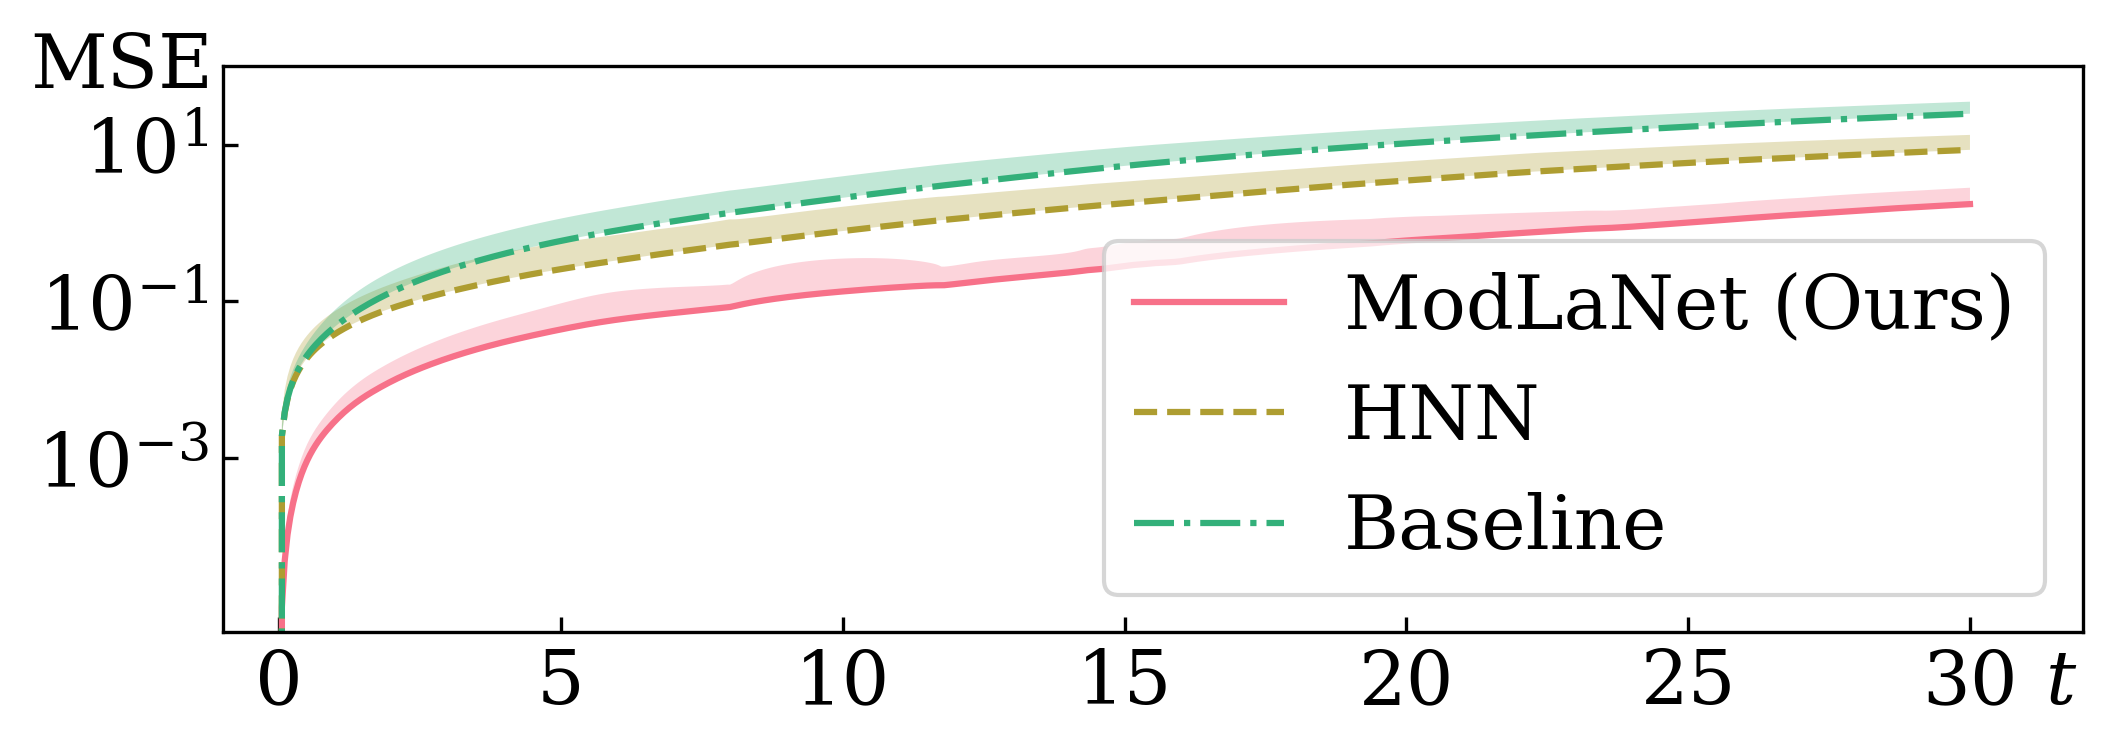

In [15]:
# Ref: https://stackoverflow.com/questions/43064524/plotting-shaded-uncertainty-region-in-line-plot-in-matplotlib-when-data-has-nans
import seaborn as sns

fig, ax = plt.subplots(figsize = [8, 2.5], dpi=DPI)
clrs = sns.color_palette("husl", 5)
labels = ['ModLaNet (Ours)', 'HNN', 'Baseline', 'LightHNN', 'LightBaseline']
lines  = ['solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5, 1, 5)),
          (0, (1, 10)), (0, (5, 10)), (0, (3, 10, 1, 10)), 
           (0, (3, 10, 1, 10, 1, 10))] #'loosely dotted', 'loosely dashed', 'loosely dashdotted', 'dashdotdotted' and 'loosely dashdotdotted'

x_array = np.array(x_list, dtype=np.float32)
# with sns.axes_style("darkgrid"):
epochs = np.linspace(t_span[0], t_span[1], end_time*timescale+1)
for i in range(3):
    x_error = x_array[i+1] - x_array[0]
    x_error = np.linalg.norm(x_error, axis = 1)
    meanst = np.mean(x_error, axis = 0)
    sdt = np.std(x_error, axis = 0)
    ax.plot(epochs, meanst, label=labels[i], c=clrs[i], linestyle=lines[i])
    ax.fill_between(epochs, meanst, meanst+sdt ,alpha=0.3, facecolor=clrs[i])
ax.legend()
ax.set_yscale('log')
ax.tick_params(axis="y", direction='in')#, length=8)
ax.tick_params(axis="x", direction='in')#, length=8)
ax.set_ylim(top=1e2)
ax.set_xlim([-1, 32])
ax.set_yticks([0.001, 0.1, 10])
ax.annotate('$t$', xy=(0.98, -0.025), ha='left', va='top', xycoords='axes fraction')
ax.annotate('MSE', xy=(-0.07, 1.05), xytext=(-15,2), ha='left', va='top', xycoords='axes fraction', textcoords='offset points')

# ax.grid('on')
fig.savefig('{}/body-3-100traj-pos.png'.format(args.result_dir))


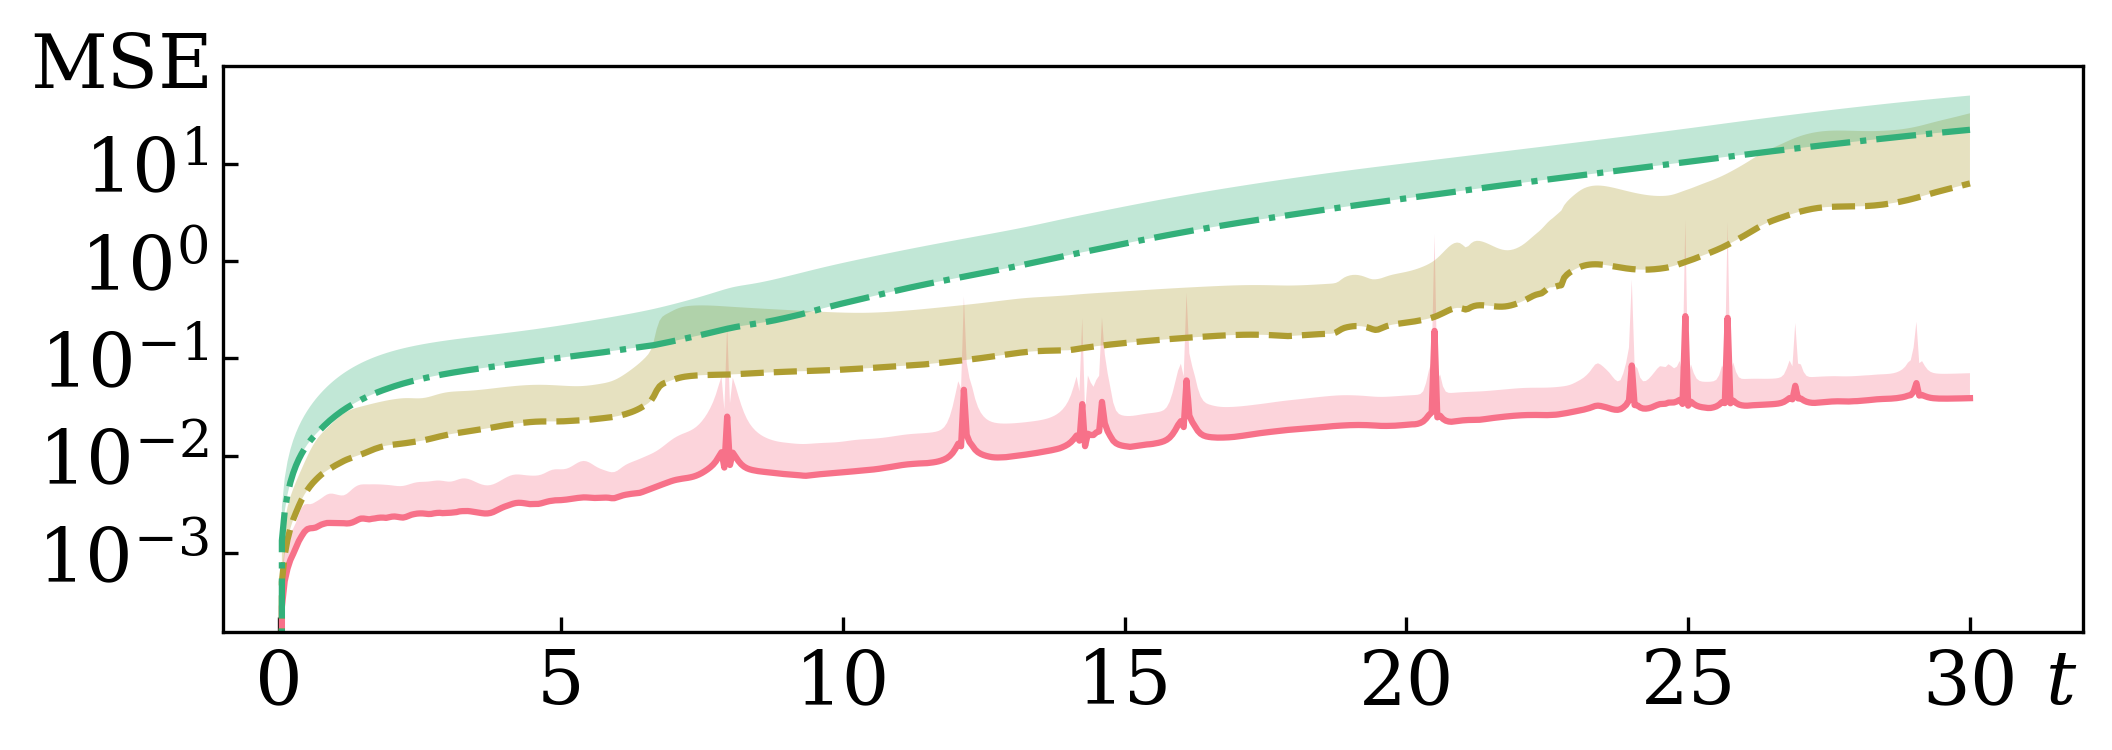

In [16]:
# Ref: https://stackoverflow.com/questions/43064524/plotting-shaded-uncertainty-region-in-line-plot-in-matplotlib-when-data-has-nans
import seaborn as sns

fig, ax = plt.subplots(figsize = [8, 2.5], dpi=DPI)
clrs = sns.color_palette("husl", 5)
labels = ['ModLaNet (Ours)', 'HNN', 'Baseline', 'LightHNN', 'LightBaseline']


e_array = np.array(e_list, dtype = np.float32)
# with sns.axes_style("darkgrid"):
epochs = np.linspace(t_span[0], t_span[1], end_time*timescale+1)
for i in range(3):
    e_error = e_array[i+1] - e_array[0]
    e_error = np.abs(e_error)
    meanst = np.mean(e_error, axis = 0)
    sdt = np.std(e_error, axis = 0)
    ax.plot(epochs, meanst, label=labels[i], c=clrs[i], linestyle=lines[i])
    ax.fill_between(epochs, meanst, meanst+sdt ,alpha=0.3, facecolor=clrs[i])
# ax.legend()
ax.set_yscale('log')
ax.tick_params(axis="y", direction='in')#, length=8)
ax.tick_params(axis="x", direction='in')#, length=8)
ax.set_ylim(top=1e2)
ax.set_xlim([-1, 32])
ax.set_yticks([0.001, 0.01, 0.1, 1, 10,])
ax.annotate('$t$', xy=(0.98, -0.025), ha='left', va='top', xycoords='axes fraction')
ax.annotate('MSE', xy=(-0.07, 1.05), xytext=(-15,2), ha='left', va='top', xycoords='axes fraction', textcoords='offset points')
# plt.xlabel('Time', horizontalalignment='right', x=1.0)
# plt.ylabel('MSE', horizontalalignment='right', y=1.0)

# ax.grid('on')
fig.savefig('{}/body-3-100traj-eng.png'.format(args.result_dir))
